In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import glob
import pickle
from scipy.linalg import hankel
from scipy.stats import dirichlet, poisson 
from scipy.special import factorial, logsumexp
import statsmodels.api as sm
import matplotx
from multiprocessing import Pool
from time import time
from tqdm import tqdm
plt.style.use(matplotx.styles.aura["dark"])

In [3]:
def trial_xticks(ax, xlocs, yloc=-0.04):
    xlocs = np.array(xlocs)
    ax.set_xticks(xlocs)
    ax.set_xticklabels([])
    ax.tick_params("x", length=17, width=1, which="major")
    ax.set_xlabel("Time", labelpad=10)

    periods = ["S", "Cue", "Delay", "Arm", "Reward"]
    for i in range(5):
        xloc = xlocs[i] + (xlocs[i + 1] - xlocs[i]) / 2
        ax.text(
            xloc,
            yloc,
            periods[i],
            fontsize=10,
            horizontalalignment="center",
            verticalalignment="top",
            transform=ax.get_xaxis_transform(),
            rotation=0,
        )


def nll(w, X, y):
    lam = np.exp(X @ w)
    # print(lam.shape)
    return -1 * y.T @ np.log(lam) + lam.sum() - 0.5 * w.T @ w


colors = ["tab:red", "tab:blue"]

In [4]:
with open("test_data_acc_ind_492_0607.pickle", "rb") as handle:
    data = pickle.load(handle)
print(data.keys())
total_neurons = len(data["spikes"])
print(f"n_neurons: {total_neurons}")
print("n_trials: {}".format(data["choice"].size))

dict_keys(['nCues_RminusL', 'currMaze', 'laserON', 'trialStart', 'trialEnd', 'keyFrames', 'time', 'cueOnset_L', 'cueOnset_R', 'choice', 'trialType', 'spikes', 'timeSqueezedFR'])
n_neurons: 324
n_trials: 290


In [5]:
# constructing design matrix with all trials and all neurons
np.random.seed(0)
X_all = []
y_all = []
trial_indices = np.nonzero(data["currMaze"] > 0)[0]
print(f"number of trials: {trial_indices.size}")
filt_len = 30
bin_size = 0.35
n_neurons = 5
neuron_idx = np.random.randint(0, total_neurons, size=n_neurons)
# neuron_idx = np.array([11, 12])
trial_id = []  # this will keep track of each trial in the design matrix (since each trial spans multiple rows)
for i, neuron in enumerate(neuron_idx):
    X = []
    y = []

    for trial_idx in trial_indices:
        trial_start = data["trialStart"][trial_idx]
        trial_end = data["trialEnd"][trial_idx]
        trial_length = trial_end - trial_start

        keyframes = data["keyFrames"][trial_idx]
        keyframe_times = data["time"][trial_idx][keyframes.astype(int)].tolist()
        lcue_times = data["cueOnset_L"][trial_idx]
        rcue_times = data["cueOnset_R"][trial_idx]
        
        spikes = data["spikes"][neuron]
        spikes = spikes[(spikes > trial_start) * (spikes < trial_end)]

        bins = np.arange(0, trial_length, bin_size)
        bin_centers = np.convolve(bins, [0.5, 0.5], mode="valid")

        binned_stimr, _ = np.histogram(rcue_times, bins)
        binned_stiml, _ = np.histogram(lcue_times, bins)
        binned_ev = np.cumsum(binned_stimr) - np.cumsum(binned_stiml)
        binned_spikes, _ = np.histogram(spikes - trial_start, bins)

        padded_stimr = np.pad(binned_stimr, (filt_len - 1, 0), constant_values=(0, 0))
        X_sr = hankel(padded_stimr[: -filt_len + 1], padded_stimr[-filt_len:])
        padded_stiml = np.pad(binned_stiml, (filt_len - 1, 0), constant_values=(0, 0))
        X_sl = hankel(padded_stiml[: -filt_len + 1], padded_stiml[-filt_len:])
        padded_ev = np.pad(binned_ev, (filt_len - 1, 0), constant_values=(0, 0))
        X_ev = hankel(padded_ev[: -filt_len + 1], padded_stiml[-filt_len:])

    

        padded_spikes = np.pad(
            binned_spikes[:-1], (filt_len, 0), constant_values=(0, 0)
        )
        X_sp = hankel(padded_spikes[: -filt_len + 1], padded_spikes[-filt_len:])

        X.append(np.hstack((X_sr, X_sl, X_sp, np.ones((X_sp.shape[0], 1)))))
        y.append(binned_spikes[:, np.newaxis])
        if i == 0:
            trial_id.append(trial_idx * np.ones(X_sr.shape[0]))

    X_all.append(np.vstack(X))
    y_all.append(np.vstack(y))

trial_id = np.concatenate(trial_id)
X_all = np.array(X_all)
y_all = np.array(y_all)
print(y_all.shape, X_all.shape)

number of trials: 290
(5, 13238, 1) (5, 13238, 91)


In [6]:
#initial glm with no states to estimate weights
theta_init = np.empty((X_all[0].shape[1], n_neurons))
# glms = [None for _ in range(n_neurons)]
sta = (X_all.transpose(0, 2, 1) @ y_all).squeeze() / y_all.sum(axis=1)

for neuron in range(n_neurons):
    
    # print(X_all[neuron].shape, y_all[neuron].shape, sta[neuron].shape)
    glm = sm.GLM(endog=y_all[neuron].squeeze(), exog=X_all[neuron], family=sm.families.Poisson())
    # glms[neuron] = glm
    a = 1 * np.ones(X_all.shape[2])
    a[-1] = 0
    res = glm.fit_regularized(alpha=a, L1_wt=0.0, maxiter=1000, cnvrg_tol=1e-6)
    # res = glm.fit(max_iter=1000, tol=1e-6, tol_criterion="params")
    w = res.params
    theta_init[:, neuron] = w
# print(a.shape)

100%|██████████| 15/15 [01:48<00:00,  7.22s/it]


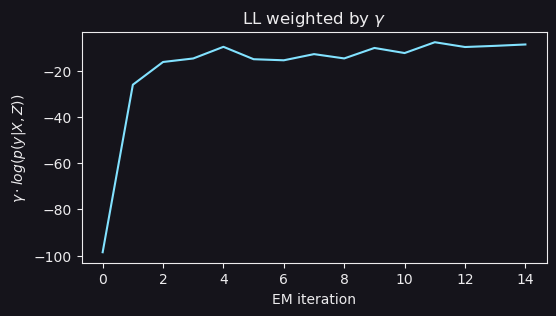

In [24]:
# with functions
n_states = 3
n_trials = trial_indices.size
theta_hmm = np.ones((n_states, X_all.shape[2], n_neurons)) * theta_init
# adding noise to all the weights
theta_hmm += np.random.normal(0, .01, size=theta_hmm.shape)
t_init = np.array([5, 1, 1])
# placing higher bias on self-transition
T = np.array([dirichlet(np.roll(t_init, n)).rvs()[0] for n in range(n_states)])
T = np.log(T)
pi = np.log(np.ones(n_states)) - np.log(n_states)
xi = np.empty((n_trials-1, n_states, n_states))
scale = np.empty(n_trials)
total_ll = []



def get_poiss_ll(X, y, theta):
    v = X @ theta
    r = np.exp(v)
    ll = y * np.log(r) - r
    ll = ll.sum(axis=(0, 1))
    return ll - logsumexp(ll)

def forward(X, y, theta, T, pi, trial_id):
    n_trials = np.unique(trial_id).size
    n_states = theta.shape[0]
    alpha = np.empty((n_states, n_trials))
    predict = np.empty(alpha.shape)
    loglikeli = np.empty(alpha.shape)

    for t in range(n_trials):
        x_idx = np.argwhere(trial_id==t).squeeze()
        # predict
        if t == 0:
            predict[:, t] = pi
        else:
            pred = []
            for tran in T.T:
                pred.append(logsumexp(tran + alpha[:, t-1]))
            predict[:, t] = np.array(pred)

        loglikeli[:, t] = get_poiss_ll(X[:, x_idx], y[:, x_idx], theta_hmm.transpose(2, 1, 0))
        # update
        update = loglikeli[:, t] + predict[:, t]
        scale[t] = logsumexp(update)
        update -= scale[t]
        alpha[:, t] = update

    return alpha, loglikeli, scale, predict


for _ in tqdm(range(15)):
    
    alpha, loglikeli, scale, predict = forward(X_all, y_all, theta_hmm, T, pi, trial_id)

    beta = np.empty(alpha.shape)
    beta[:, -1] = 0  # in log form
    for t in range(n_trials-2, -1, -1):
        b_up = []
        for tran in T:
            beta_update = tran + beta[:, t+1] + loglikeli[:, t+1]
            b_up.append(logsumexp(beta_update))
        beta[:, t] = np.array(b_up) - scale[t+1]
    gamma = alpha + beta
    gamma -= logsumexp(gamma, axis=0) 

    total_ll.append((np.exp(gamma) * loglikeli).sum())


    for t in range(0, n_trials-1):
        for s1 in range(n_states):
            for s2 in range(n_states):
                xi[t, s1, s2] = T[s1, s2] + alpha[s1, t] + loglikeli[s2, t+1] + beta[s2, t+1]

        xi[t] -= logsumexp(xi[t])
    
    T = logsumexp(xi, axis=0)
    T -= logsumexp(T, axis=1)[:, None]

    _, trial_counts = np.unique(trial_id, return_counts=True)
    pi = gamma[:, 0]

    # maximization
    for s in range(n_states):
        for neuron in range(n_neurons):
            weights = np.repeat(np.exp(gamma[s]), trial_counts)
            glm = sm.GLM(endog=y_all[neuron], exog=X_all[neuron], family=sm.families.Poisson(), freq_weights=weights)
            # can greatly effect outcome. too high on simulated data made it fail, basically comes down to noise level of data
            # higher noise ---> set alpha to be higher
            a = 0 * np.ones(X_all.shape[2])  
            a[-1] = 0
            res = glm.fit_regularized(alpha=a, L1_wt=0.0, maxiter=1000, cnvrg_tol=1e-6)

            w = res.params
            theta_hmm[s, :, neuron] = w

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(np.array(total_ll))
ax.set_title(r'LL weighted by $\gamma$')
ax.set_xlabel('EM iteration')
ax.set_ylabel(r'$\gamma \cdot log(p(y | X, Z))$');

In [9]:
fname = 'run000.pickle'
out = {
    'neuron_idx': neuron_idx,
    'T': T,
    'alpha': alpha,
    'gamma': gamma,
    'beta': beta,
    'loglikeli': loglikeli,
    'theta': theta_hmm,
    'total_ll': total_ll,
    'predict': predict
}
with open(fname, 'wb') as handle:
    pickle.dump(out, handle)

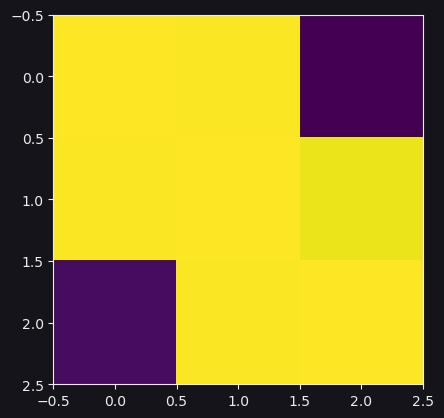

In [11]:
with open(fname, 'rb') as handle:
    rd = pickle.load(handle)


(array([[184.,   2.,   0.,   0.,   0.,   0.,   1.,   2.,   0., 101.],
        [180.,   0.,   2.,   1.,   0.,   0.,   0.,   0.,   2., 105.],
        [211.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  79.]]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 3 BarContainer objects>)

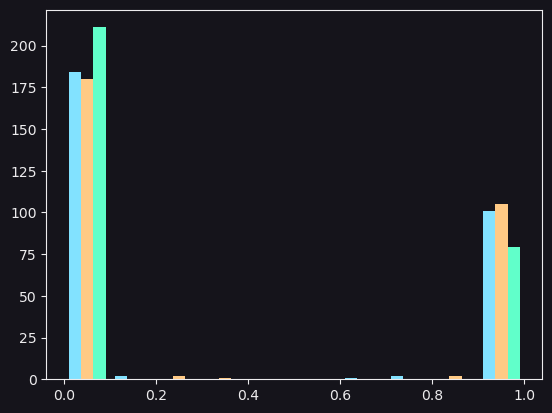

In [22]:
plt.hist(np.exp(gamma.T))


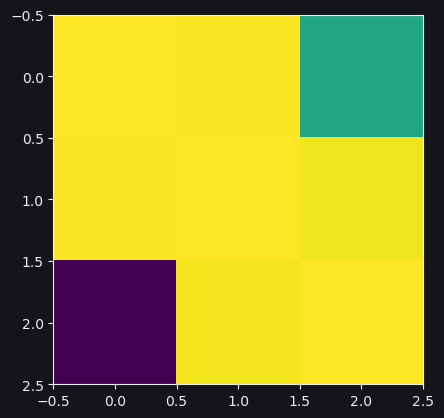

In [23]:
plt.imshow(T)

Spike history of other neurons to determine current neuron activity? Seems like a reasonable feature in a connected network